Install Contrastive

In [1]:
!pip install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6898 sha256=9d397164ac5dbca84ca765dbde4f618eb32785bd52a55e4942f20104cf9f745a
  Stored in directory: /root/.cache/pip/wheels/b4/2a/ad/111239c0d6a0b248f0ee4b903b6b44cc9cdfc1cfcff81ebba2
Successfully built contrastive


Download Iris dataset

In [51]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import numpy as np

data = load_digits()
print(data.keys())


X_data = np.asarray(data["data"])
y_data = np.asarray(data["target"])

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [54]:
print(X_data.shape)
print(y_data.shape)

(1797, 64)
(1797,)


Create a noise generator feature

In [52]:
N_DIM = X_data.shape[1]
N_ROWS = X_data.shape[0]
X_data_noise = np.zeros((N_DIM, N_ROWS))
for feature in range(N_DIM):
    original_mean = np.mean(X_data[:, feature])
    original_std = np.std(X_data[:, feature])
    X_data_noise[feature] = np.random.normal(original_mean, original_std, N_ROWS)

Visualize real data and data with noise generation

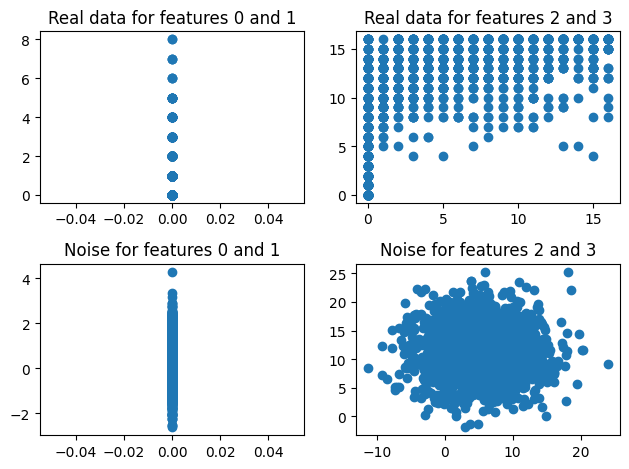

In [53]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title("Real data for features 0 and 1")
axs[0, 0].scatter(X_data[:, 0], X_data[:, 1])
axs[0, 1].set_title("Real data for features 2 and 3")
axs[0, 1].scatter(X_data[:, 2], X_data[:, 3])
axs[1, 0].set_title("Noise for features 0 and 1")
axs[1, 0].scatter(X_data_noise[0], X_data_noise[1])
axs[1, 1].set_title("Noise for features 2 and 3")
axs[1, 1].scatter(X_data_noise[2], X_data_noise[3])
fig.tight_layout()

Implement PCA on 2 dimensions

In [58]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
X_data_original_compress = pca_model.fit_transform(X_data)

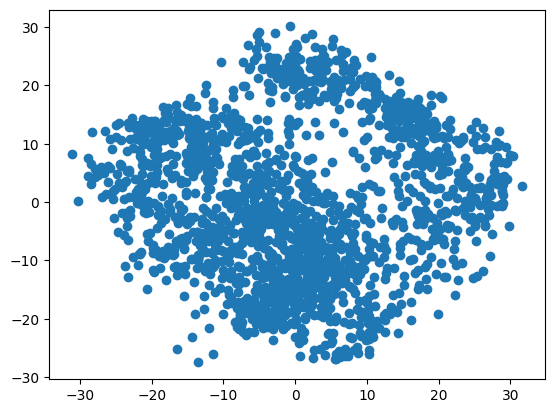

In [59]:
plt.scatter(X_data_original_compress[:, 0], X_data_original_compress[:, 1])

Run PCA

In [60]:
from contrastive import CPCA

print(X_data.shape)
print(X_data_noise.T.shape)
cpca_model = CPCA(n_components=2)
transformed_data = cpca_model.fit_transform(X_data, X_data_noise.T)
transformed_data = np.asarray(transformed_data)
print(transformed_data.shape)

(1797, 64)
(1797, 64)


/usr/local/lib/python3.10/dist-packages/contrastive/__init__.py:40: RuntimeWarning: invalid value encountered in divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


(4, 1797, 2)


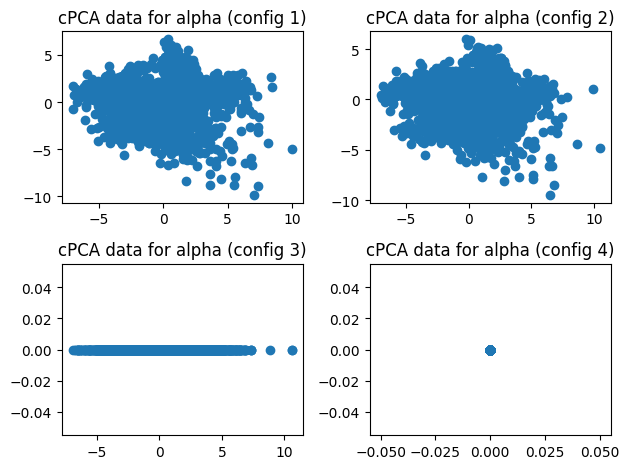

In [61]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
P = transformed_data
axs[0, 0].set_title("cPCA data for alpha (config 1)")
axs[0, 0].scatter(P[0, :, 0], P[0, :, 1])
axs[0, 1].set_title("cPCA data for alpha (config 2)")
axs[0, 1].scatter(P[1, :, 0], P[1, :, 1])
axs[1, 0].set_title("cPCA data for alpha (config 3)")
axs[1, 0].scatter(P[2, :, 0], P[2, :, 1])
axs[1, 1].set_title("cPCA data for alpha (config 4)")
axs[1, 1].scatter(P[3, :, 0], P[3, :, 1])
fig.tight_layout()

Running k-NN on PCA-compressed data

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data_original_compress, y_data
    )
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.62267 +/- 0.02235


Running k-NN on original dataset

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.98533 +/- 0.00285


Running on cPCA-compressed data, with different values for alpha (cPCA parameter)

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

for i in range(len(transformed_data)):
    mean_acc = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(transformed_data[i], y_data)
        knn_clf = KNeighborsClassifier(n_neighbors=5)
        knn_clf.fit(X_train, y_train)
        mean_acc.append(knn_clf.score(X_test, y_test))
    print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.53822 +/- 0.01596
0.49444 +/- 0.01634
0.33378 +/- 0.025
0.08867 +/- 0.0103
